# Rayleigh plot for Circadian Rhythm Research
# 6/22/20 update
1. SD added inside around arrow. Width = SD. Length set at 50% of arrow length
2. stacked points added. Factor controls how far the points go inwards. Default = 0.1, which means points \
    go from 1, 0.9, 0.8...

Note: seems like it will be difficult to plot things outside of graph for python

# 10/28/20 update
## add body temperature tutorial
1. dummy data: cosine curve with mean temperature at 36 deg C with a 0.2 deg C range; peak @ ~9pm local time
   This is based on a class experiment I ran as a TA with 100 undergrads.
2. raw data is smoothened and fit to a cosine curve and peaks are located and averaged.
3. Averaged peaks are plotted on Rayleigh plots.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import astropy.stats.circstats as cs
import circular
import numpy as np
import math
from scipy import optimize, signal
import random
from scipy.signal import find_peaks

# 0. Utility functions

In [13]:
# save figure with given figure name
def save_fig(fig_id, tight_layout=True):
    os.makedirs('plots', exist_ok = True)
    path = os.path.join('plots',fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# return vector length r with given pval and number of observations n
def reverse_circa_r_test(pval,n):
    R = 4*n**2-(((1+2*n)+np.log(pval))**2-(1+4*n))
    R = np.sqrt(R/4)
    r = R/n
    return r

# introduce jitter for stacked points presentation
# default factor 0.1 means points goes from 1,0.9,0.8...
def descending_occurence(df, factor = 0.1):
    df['range'] = list(range(len(df)))
    df['ones'] = np.ones_like(df['range']) - factor*df['range']
    del df['range']
    return df

# 1. Plotting function for Rayleigh Plots

In [14]:
# setup layout for plotting
# schedule: ZT vs CT
def rayleigh_plot_setup(ax, schedule):

    # suppress the radial labels
    plt.setp(ax.get_yticklabels(), visible=False)

    # set the circumference labels
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    ax.set_xticklabels(range(24))

    # make the labels go clockwise
    ax.set_theta_direction(-1)

    # place 0 at the top
    if schedule == 'human':
        ax.set_theta_offset(np.pi)
    else:
        ax.set_theta_offset(np.pi/2.0)
    for i in range(90,270):
        if schedule == 'ZT' or schedule == 'human':
            day_color = 'yellow'
        elif schedule == 'CT':
            day_color = 'lightgrey'
        else:
            day_color = 'white'
            print('invalid schedule')
        plt.axvspan(i*2*np.pi/360, (i+1)*2*np.pi/360, alpha=0.1, color= day_color)

    for i in range(-90,90):
        plt.axvspan(i*2*np.pi/360, (i+1)*2*np.pi/360, alpha=0.1, color='dimgrey')


In [15]:
# plotting rayleigh plots of multiple data groups on the same plot
# df: dataframe
# phase_in_hrs:  phase in hours
# group: groups to seperate dataset
# fname: file name to save
# schedule: ZT/CT plotting for background
# stacked: stacked points or not
# factor: scaling factor for stacked points
def rayleigh_plot_same(df, phase_in_hrs, group,fname, schedule = 'ZT', stacked = False, factor = 0.1):
    
    df['phase'] = df[phase_in_hrs]*(2*np.pi/24) # convert phase in hours to phase in radian
    colors = ['b','r','g','c','m','y','k'] # color list for plotting
    
    # plot setup
    plt.figure(figsize = (8,8))
    ax = plt.subplot(111, polar=True)
    rayleigh_plot_setup(ax, schedule)
    legend_list = []
    
    # making plot for each group
    for g in range(len(df[group].unique())):
        plotting = df[df[group]==df[group].unique()[g]]
        # introduce jitter if stacked, otherwise all points have radius of 1
        if stacked:
            tmp = pd.DataFrame(columns = plotting.columns)
            for t in plotting['phase'].unique():
                subset = plotting[plotting['phase'] == t]
                subset = descending_occurence(subset, factor)
                tmp = tmp.append(subset)
            plotting = tmp        
        else:
            plotting['ones'] = np.ones_like(plotting['phase'])
        # plot data points
        points = ax.scatter(plotting['phase'], plotting['ones'], color = colors[g], label = df[group].unique()[g])
        # plot arrow: length = mean vector of all points in the group
        arr_dir = cs.circmean(plotting['phase'])
        arr_len = circular.circ_r(plotting['phase'])
        kw = dict(arrowstyle="->", color=colors[g],linewidth = 5)
        ax.annotate("", xy=(arr_dir, arr_len), xytext=(0, 0),
                 arrowprops=kw)
        # plot lateral SD bar. width = +/- SD, length set at half of arrow length
        sd = np.sqrt(cs.circvar(plotting['phase']))
        ax.plot(np.linspace(arr_dir - sd, arr_dir + sd, 100), np.ones(100)*arr_len*0.5, color='black', linestyle='-')
        # show legend
        plt.legend()
        print('Group: ', df[group].unique()[g], 'Mean Phase: ', arr_dir, 'Mean Vecor Length: ', arr_len, 'SD: ', sd)
    
    # put the points on the circumference
    plt.ylim(0,1.02)
    
    #plt.legend(handles = legend_list, loc = 'upper center',bbox_to_anchor=(1.3, 0.8))
    plt.title(fname,y = 1.1)
    plt.grid('off')

    save_fig(fname)
    plt.show()

In [16]:
# plotting rayleigh plots of multiple data groups on separate, individual plots
# df: dataframe
# phase_in_hrs: ZT/CT phase in hours
# group: groups to seperate dataset
# fname: file name to save
# schedule: ZT/CT plotting for background
# stacked: stacked points or not
# factor: scaling factor for stacked points
def rayleigh_plot_separate(df, phase_in_hrs, group,fname, schedule = 'ZT', stacked = False, factor = 0.1):
    
    df['phase'] = df[phase_in_hrs]*(2*np.pi/24) # convert phase in hours to phase in radian
    colors = ['b','r','g','c','m','y','k'] # color list for plotting
    # figure setup
    n_plot = df[group].nunique()
    plt.figure(figsize = (8,4))
    # plot individual group
    for g in range(len(df[group].unique())):
        # plot setup
        ax = plt.subplot(1,n_plot, g+1, polar=True, clip_on = False)
        rayleigh_plot_setup(ax, schedule)
        legend_list = []
        plotting = df[df[group]==df[group].unique()[g]]
        # introduce jitter if stacked, else all points have radius of 1
        if stacked:
            tmp = pd.DataFrame(columns = plotting.columns)
            for t in plotting['phase'].unique():
                subset = plotting[plotting['phase'] == t]
                subset = descending_occurence(subset, factor)
                tmp = tmp.append(subset)
            plotting = tmp
        else:
            plotting['ones'] = np.ones_like(plotting['phase'])
        # reverse R test ring to show 0.05 significance threshold   
        R_test = reverse_circa_r_test(0.05, len(plotting))
        ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*R_test, color='orange', linestyle='-')
        # plot points
        points = ax.scatter(plotting['phase'], plotting['ones'], color = colors[g], label = df[group].unique()[g])
        # plot arrow, length = mean vector length of all points in the group
        arr_dir = cs.circmean(plotting['phase'])
        arr_len = circular.circ_r(plotting['phase'])
        kw = dict(arrowstyle="->", color=colors[g], linewidth = 3)
        ax.annotate("", xy=(arr_dir, arr_len), xytext=(0, 0),
                 arrowprops=kw)
        # plot sd line. width = +/- SD, length set at half of arrow length
        sd = np.sqrt(cs.circvar(plotting['phase']))
        ax.plot(np.linspace(arr_dir - sd, arr_dir + sd, 100), np.ones(100)*arr_len*0.5, color='black', linestyle='-')

        # put the points on the circumference
        plt.ylim(0,1.05)
        plt.title(fname + '_' + df[group].unique()[g],y = 1.1)
        plt.grid('off')
        
        print('Group: ', df[group].unique()[g], 'Mean Phase: ', arr_dir, 'Mean Vecor Length: ', arr_len, 'SD: ', sd)
    
    save_fig(fname + '_sep')
    plt.show()


# 2. Generate dummy body temperature data and preprocessing

In [17]:
# Global parameters of dummy body temperature data
mean_temp = 36
days = 7
n = 24*60*days
amp = 0.2
x_data = np.linspace(0,days*24, num= n)

# get_temp
# Input: base_phase - average phase of the dummy data
#        phase_range - range of phase
# Return: y_data - the dummy data 
# dummy data include randomness in both x and y directions.
def get_temp(base_phase = 19, phase_range = 2):
    np.random.seed(0)
    phase = (random.random()-0.5)*phase_range + base_phase 
    y_data = mean_temp + amp*np.cos(2*math.pi*(x_data - phase)/24) + np.random.normal(size=n)/50
    return  y_data

# test_func - return cosine curve to be fitted
def test_func(x, a, b,c):
    return mean_temp+ a * np.cos(c + b * x*2*math.pi/24)

# get_smooth - return smoothened data (y_data_smooth) from raw_data (y_data)
def get_smooth(y_data):
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data)
    y_data_smooth = test_func(x_data, params[0], params[1],params[2])
    return y_data_smooth

# return all peaks found by numpy's find peaks
def get_peaks(y_data_smooth):
    return x_data[find_peaks(y_data_smooth, height=0)[0]]
      
# from list of peaks from multiple days of recording return the average peak 
def get_avg_peaks(peaks):
    avg_peak = (peaks - [24*i for i in range(len(peaks))]).mean()
    return avg_peak

In [18]:
# plotting function to plot the raw body temperature data, the smoothened data and the first peak found
def get_tmp_plots(y_data):
    plt.figure(figsize=(6, 4))
    plt.scatter(x_data, y_data, label='Raw Data')
    y_data_smooth = get_smooth(y_data)
    plt.plot(x_data, y_data_smooth,
             label='Fitted function',color = 'red')
    peaks = get_peaks(y_data_smooth)
    plt.axvline(peaks[0], label = 'Peak', color = 'green')
    plt.legend(loc='best')
    plt.xticks([24*i for i in range(days)])
    plt.xlabel('Time (h)')
    plt.ylabel('Body Temperature (deg C)')
    plt.title('Daily fluctuation of Body Temperature')
    plt.show()

In [19]:
# A master function to generate dummy temperature data and return their peaks
def get_all_data(base_phase, phase_range, group_name, num_samples = 20):
    y_raw = ([get_temp(base_phase, phase_range) for _ in range(num_samples)])
    y_smooth = [get_smooth(y_raw[i]) for i in range(len(y_raw))]
    y_peaks = [get_peaks(y_smooth[i]) for i in range(len(y_smooth))]
    y_avg_peaks = [get_avg_peaks(y_peaks[i]) for i in range(len(y_peaks))]
    
    peaks = pd.DataFrame({'Local Time': y_avg_peaks,'Exp_Group':[group_name]*num_samples})
    return peaks , y_raw

# 3. Main Program

In [92]:
ctrl_peaks, ctrl_trace = get_all_data(base_phase = 19, phase_range = 1, group_name = 'Control')
shifted_peaks, shifted_trace = get_all_data(base_phase = 13, phase_range = 4, group_name = 'Shifted')

In [22]:
peaks = pd.concat([ctrl_peaks, shifted_peaks ])

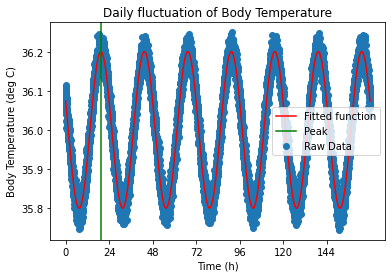

In [29]:
get_tmp_plots(ctrl_trace[0])

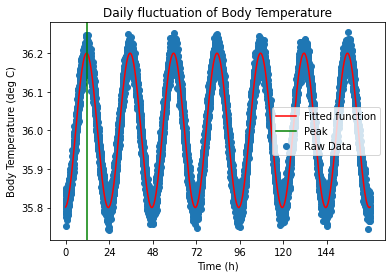

In [30]:
get_tmp_plots(shifted_trace[0])

In [23]:
peaks.head()

,Local Time,Exp_Group
0,19.435261,Control
1,19.463836,Control
2,18.923306,Control
3,18.913781,Control
4,19.016172,Control


In [31]:
df = pd.DataFrame(columns=['Local Time', 'Exp_Group'])
df

,Local Time,Exp_Group


In [34]:
df = pd.concat([df,peaks])
len(df)

120

/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Group:  Control Mean Phase:  -1.3169566571957225 Mean Vecor Length:  0.9977790338183727 SD:  0.047127127873735006
Group:  Shifted Mean Phase:  -2.8109802767900134 Mean Vecor Length:  0.9610698944072114 SD:  0.19730713517961923
Saving figure Test rayleigh plot_sep


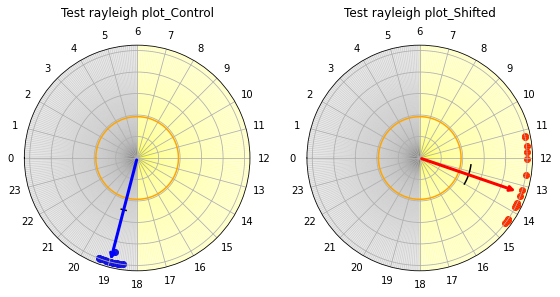

In [607]:
rayleigh_plot_separate(peaks,'Local Time','Exp_Group', 'Test rayleigh plot', schedule = 'human', stacked = True, factor = 0.1)



/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Group:  Control Mean Phase:  -1.3169566571957225 Mean Vecor Length:  0.9977790338183727 SD:  0.047127127873735006
Group:  Shifted Mean Phase:  -2.8109802767900134 Mean Vecor Length:  0.9610698944072114 SD:  0.19730713517961923
Saving figure Test rayleigh plot


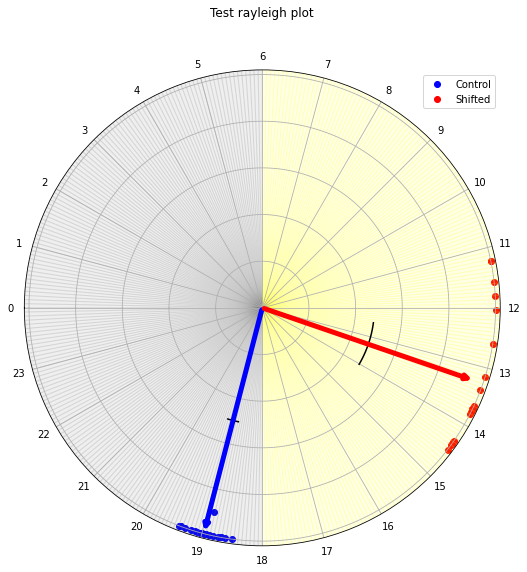

In [608]:
rayleigh_plot_same(peaks,'Local Time','Exp_Group', 'Test rayleigh plot', schedule = 'human', stacked=True)

In [609]:
#for i in range(len(y_raw)):
#    get_tmp_plots(y_raw[i])

In [39]:
len(x_data)

10080

In [38]:
len(ctrl_trace[0])

10080

In [93]:
ctrl_traces = pd.DataFrame(ctrl_trace).transpose()
shifted_traces = pd.DataFrame(shifted_trace).transpose()

ctrl_traces = ctrl_traces.add_prefix('Group1_')
shifted_traces = shifted_traces.add_prefix('Group2_')


In [94]:
ctrl_traces.index = x_data
shifted_traces.index = x_data
data = ctrl_traces.merge(shifted_traces, left_index = True, right_index = True)

In [95]:
shifted_traces.head()

,Group2_0,Group2_1,Group2_2,Group2_3,Group2_4,Group2_5,Group2_6,Group2_7,Group2_8,Group2_9,Group2_10,Group2_11,Group2_12,Group2_13,Group2_14,Group2_15,Group2_16,Group2_17,Group2_18,Group2_19
0.000000,35.864075,35.866466,35.835991,35.835825,35.839189,35.840224,35.841034,35.844943,35.840473,35.879027,35.882730,35.865871,35.835753,35.838079,35.865977,35.836892,35.869655,35.871914,35.847189,35.835551
0.016668,35.836348,35.838722,35.808789,35.808613,35.812085,35.813141,35.813550,35.817399,35.813000,35.851205,35.854889,35.838131,35.808537,35.810949,35.838236,35.809727,35.841889,35.844134,35.819617,35.808229
0.033337,35.847473,35.849830,35.820440,35.820255,35.823834,35.824911,35.824919,35.828708,35.824379,35.862237,35.865901,35.849243,35.820174,35.822671,35.849348,35.821415,35.852976,35.855207,35.830897,35.819761
0.050005,35.872273,35.874614,35.845766,35.845572,35.849258,35.850356,35.849964,35.853692,35.849434,35.886943,35.890587,35.874031,35.845486,35.848069,35.874135,35.846778,35.877738,35.879955,35.855852,35.844969
0.066673,35.864367,35.866690,35.838386,35.838183,35.841976,35.843095,35.842302,35.845970,35.841783,35.878942,35.882566,35.866111,35.838093,35.840761,35.866215,35.839435,35.869793,35.871996,35.848102,35.837470


In [96]:
data.head()

,Group1_0,Group1_1,Group1_2,Group1_3,Group1_4,Group1_5,Group1_6,Group1_7,Group1_8,Group1_9,...,Group2_10,Group2_11,Group2_12,Group2_13,Group2_14,Group2_15,Group2_16,Group2_17,Group2_18,Group2_19
0.000000,36.092404,36.066902,36.065863,36.069735,36.089203,36.091809,36.084757,36.104799,36.091902,36.107466,...,35.882730,35.865871,35.835753,35.838079,35.865977,35.836892,35.869655,35.871914,35.847189,35.835551
0.016668,36.064289,36.038762,36.037722,36.041598,36.061084,36.063693,36.056633,36.076703,36.063787,36.079373,...,35.854889,35.838131,35.808537,35.810949,35.838236,35.809727,35.841889,35.844134,35.819617,35.808229
0.033337,36.075022,36.049471,36.048430,36.052309,36.071814,36.074426,36.067358,36.087454,36.074520,36.090129,...,35.865901,35.849243,35.820174,35.822671,35.849348,35.821415,35.852976,35.855207,35.830897,35.819761
0.050005,36.099426,36.073851,36.072809,36.076690,36.096214,36.098829,36.091753,36.111875,36.098923,36.114555,...,35.890587,35.874031,35.845486,35.848069,35.874135,35.846778,35.877738,35.879955,35.855852,35.844969
0.066673,36.091120,36.065521,36.064478,36.068362,36.087903,36.090522,36.083437,36.103586,36.090616,36.106270,...,35.882566,35.866111,35.838093,35.840761,35.866215,35.839435,35.869793,35.871996,35.848102,35.837470


In [97]:
data.columns

Index(['Group1_0', 'Group1_1', 'Group1_2', 'Group1_3', 'Group1_4', 'Group1_5',
       'Group1_6', 'Group1_7', 'Group1_8', 'Group1_9', 'Group1_10',
       'Group1_11', 'Group1_12', 'Group1_13', 'Group1_14', 'Group1_15',
       'Group1_16', 'Group1_17', 'Group1_18', 'Group1_19', 'Group2_0',
       'Group2_1', 'Group2_2', 'Group2_3', 'Group2_4', 'Group2_5', 'Group2_6',
       'Group2_7', 'Group2_8', 'Group2_9', 'Group2_10', 'Group2_11',
       'Group2_12', 'Group2_13', 'Group2_14', 'Group2_15', 'Group2_16',
       'Group2_17', 'Group2_18', 'Group2_19'],
      dtype='object')

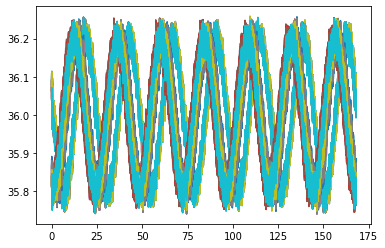

In [98]:
plt.plot(data)

In [99]:
data.to_csv('example_raw_traces.csv')

In [100]:
data.index

Float64Index([                0.0, 0.01666832026986804, 0.03333664053973608,
              0.05000496080960412, 0.06667328107947217, 0.08334160134934021,
              0.10000992161920824, 0.11667824188907629, 0.13334656215894433,
              0.15001488242881236,
              ...
               167.84998511757118,  167.86665343784105,  167.88332175811092,
               167.89999007838077,  167.91665839865064,   167.9333267189205,
               167.94999503919038,  167.96666335946026,  167.98333167973013,
                            168.0],
             dtype='float64', length=10080)

In [114]:
col_list = list(data.columns.str.split('_'))
col_dict = {}

for i in range(len(col_list)):
    if col_list[i][0] not in col_dict:
        col_dict[col_list[i][0]] = col_list[i][0]

In [115]:
col_dict

{'Group1': 'Group1', 'Group2': 'Group2'}

In [116]:
for i in col_dict:
    print(i)

Group1
Group2


In [123]:
data[data.columns[data.columns.str.contains('Group1')]].head()

,Group1_0,Group1_1,Group1_2,Group1_3,Group1_4,Group1_5,Group1_6,Group1_7,Group1_8,Group1_9,Group1_10,Group1_11,Group1_12,Group1_13,Group1_14,Group1_15,Group1_16,Group1_17,Group1_18,Group1_19
0.000000,36.092404,36.066902,36.065863,36.069735,36.089203,36.091809,36.084757,36.104799,36.091902,36.107466,36.098391,36.088637,36.091114,36.074765,36.068130,36.088957,36.101558,36.069913,36.105886,36.064374
0.016668,36.064289,36.038762,36.037722,36.041598,36.061084,36.063693,36.056633,36.076703,36.063787,36.079373,36.070284,36.060517,36.062998,36.046631,36.039991,36.060838,36.073456,36.041775,36.077791,36.036232
0.033337,36.075022,36.049471,36.048430,36.052309,36.071814,36.074426,36.067358,36.087454,36.074520,36.090129,36.081026,36.071246,36.073730,36.057346,36.050700,36.071567,36.084203,36.052486,36.088544,36.046939
0.050005,36.099426,36.073851,36.072809,36.076690,36.096214,36.098829,36.091753,36.111875,36.098923,36.114555,36.105438,36.095646,36.098132,36.081732,36.075081,36.095967,36.108619,36.076868,36.112968,36.071318
0.066673,36.091120,36.065521,36.064478,36.068362,36.087903,36.090522,36.083437,36.103586,36.090616,36.106270,36.097139,36.087335,36.089824,36.073407,36.066751,36.087656,36.100325,36.068539,36.104680,36.062986


In [124]:
len(data.columns)

40

In [125]:
data.iloc[0]

Group1_0     36.092404
Group1_1     36.066902
Group1_2     36.065863
Group1_3     36.069735
Group1_4     36.089203
Group1_5     36.091809
Group1_6     36.084757
Group1_7     36.104799
Group1_8     36.091902
Group1_9     36.107466
Group1_10    36.098391
Group1_11    36.088637
Group1_12    36.091114
Group1_13    36.074765
Group1_14    36.068130
Group1_15    36.088957
Group1_16    36.101558
Group1_17    36.069913
Group1_18    36.105886
Group1_19    36.064374
Group2_0     35.864075
Group2_1     35.866466
Group2_2     35.835991
Group2_3     35.835825
Group2_4     35.839189
Group2_5     35.840224
Group2_6     35.841034
Group2_7     35.844943
Group2_8     35.840473
Group2_9     35.879027
Group2_10    35.882730
Group2_11    35.865871
Group2_12    35.835753
Group2_13    35.838079
Group2_14    35.865977
Group2_15    35.836892
Group2_16    35.869655
Group2_17    35.871914
Group2_18    35.847189
Group2_19    35.835551
Name: 0.0, dtype: float64